In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

In [4]:
insurance = pd.read_csv("../datasets/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 1

In [8]:
# continuous predictor variables only
X = insurance[['age', 'bmi', 'children']]
y = insurance['charges']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           8.80e-37
Time:                        19:32:28   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6916.2433   1757.480     -3.935      0.0

**Intercept**: -6916.2433, SE 1757.480, p < 0.0001  
This is the predicted charge for a newborn (age 0) with a bmi of 0, no children,
female, non-smoker, from the northeast region. This has no meaning in it of itself,
however given its extremely low p-value, is obviously extremely relevant to the
model as it anchors the regression line.

**Age**: 239.9945, SE 22.289, p < 0.0001
Holding all other variables constant, each year a patient is older is associated
with an increase of roughly $240 in insurance charge. The SE is low and p-value
is also extremely low, indicating a decently estimated and statistically significant
predictor.

**BMI**: 332.0834, SE 51.31, p < 0.0001
Holding all other variables constant, a one unit increase in BMI is associated
with an increase of roughly $332 in insurance charge. The SE is high and p-value
is extremely low, indicating an average estimate but still statistically significant
predictor.

**Children**: 542.8647, SE 258.241, p 0.036
Holding all other variables constant, every additional child is associated with
an increase of roughly $542 in insurance charge. The SE is higher than both
coefficient estimates for *age* and *bmi*, but still statistically signifcant 
at an alpha level of 0.05.

The adjusted R-squared value of the model is 0.118. This means that after accounting
for model complexity, only about 11.8% of the variation in insurnace charges is
expalined by age, BMI, and number of children. This indicates that most variation
in charges is driven by non-continuous predictor variables, which Lantz does
wish to show.

# 2

In [11]:
# recompute standard error and p values with sandwich formula

robust_cov = model.get_robustcov_results(cov_type='HC1')
print(robust_cov.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.13
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           1.85e-36
Time:                        19:40:39   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6916.2433   1703.922     -4.059      0.0

All coefficient values are the same, but this is expected as the sandwich
formula does not change the fitted coefficients, only the estimated covariance
matrix.

**Intercept**: 
The SE decreased slightly, however p-value still indicates a statistically 
significant value. This means that heteroskedasticity correction slightly
tightens uncertainty aroudn the intercept.

**Age**: 
Value remains relatively unchanged, thus the effect of age is very stable and
not sensitive to heteroskedasticity.

**BMI**: 
The SE has increased, however p-value still indicates a statistically significant
predictor variable. This means that OLS underestimated uncertainty for BMI. After
correcting, BMI is still significant but less precisely estimated.

**Children**: 
The SE decreased slightly, and p-value has decreased as well. This means that
once heteroskedasticity is accounted for, the effect of children is actually
slightly more statistically significant.

Because all coefficient values are the same, the adjusted R-squared is still 0.118.

# 3

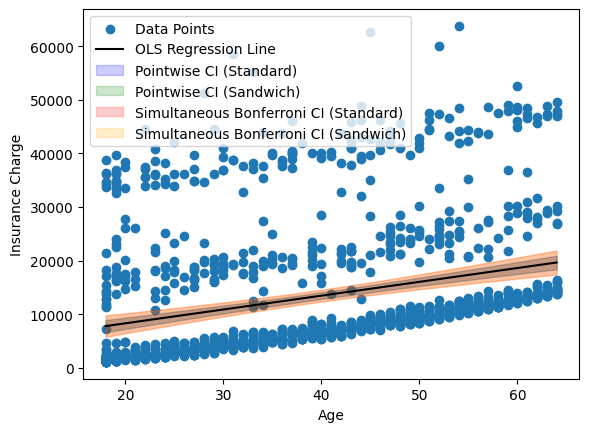

In [13]:
x = insurance['age']
y = insurance['charges']
conf = 0.95

x = np.asarray(x)
y = np.asarray(y)

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

xg = np.linspace(min(x), max(x), 100)
Xg = sm.add_constant(xg)
yhat_g = model.predict(Xg)

V_std = model.cov_params()
V_rob = model.get_robustcov_results(cov_type='HC1').cov_params()

se_std = np.sqrt(np.sum(Xg @ V_std * Xg, axis=1))
se_rob = np.sqrt(np.sum(Xg @ V_rob * Xg, axis=1))

z_point = norm.ppf(1 - (1 - conf) / 2)
z_bonf = norm.ppf(1 - (1 - conf) / (2 * len(xg)))

pw_std_u = yhat_g + z_point * se_std
pw_std_l = yhat_g - z_point * se_std

pw_rob_u = yhat_g + z_point * se_rob
pw_rob_l = yhat_g - z_point * se_rob

bonf_std_u = yhat_g + z_bonf * se_std
bonf_std_l = yhat_g - z_bonf * se_std

bonf_rob_u = yhat_g + z_bonf * se_rob
bonf_rob_l = yhat_g - z_bonf * se_rob

plt.scatter(x, y, label='Data Points')
plt.plot(xg, yhat_g, color='black', label='OLS Regression Line')

plt.fill_between(xg, pw_std_l, pw_std_u, color='blue', alpha=0.2, label='Pointwise CI (Standard)')
plt.fill_between(xg, pw_rob_l, pw_rob_u, color='green', alpha=0.2, label='Pointwise CI (Sandwich)')
plt.fill_between(xg, bonf_std_l, bonf_std_u, color='red', alpha=0.2, label='Simultaneous Bonferroni CI (Standard)')
plt.fill_between(xg, bonf_rob_l, bonf_rob_u, color='orange', alpha=0.2, label='Simultaneous Bonferroni CI (Sandwich)')

plt.xlabel('Age')
plt.ylabel('Insurance Charge')
plt.legend()
plt.show()

**LLM Usage**: All work was done by myself in VSCode with [GitHub Copilot integration](https://code.visualstudio.com/docs/copilot/overview). The integration "provides code suggestions, explanations, and automated implementations based on natural language prompts and existing code context," and also offers autonomous coding and an in-IDE chat interface that is able to interact with the current codebase. Only the Copilot provided automatic inline suggestions for both LaTex and Python in `.tex` and `.ipynb` Jupyter notebook files respectively were taken into account / used.